## Import dependencies


In [180]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

import seaborn as sns

## Read data

In [195]:
X_train = pd.read_csv("../data/train_test_val/X_train.csv", header=[0,1], index_col=0)
X_test = pd.read_csv("../data/train_test_val/X_test.csv", header=[0,1], index_col=0)
X_val = pd.read_csv("../data/train_test_val/X_val.csv", header=[0,1], index_col=0)

y_train = pd.read_csv("../data/train_test_val/y_train.csv", index_col=0) 
y_val = pd.read_csv("../data/train_test_val/y_val.csv", index_col=0)
y_test = pd.read_csv("../data/train_test_val/y_test.csv", index_col=0)

### Creating ML Pipeline

In [196]:
rfc = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knc = KNeighborsClassifier()
abc = AdaBoostClassifier(random_state=42)

models = {"rfc": rfc,"svc": svc, "knc" : knc,"abc" : abc}

In [197]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train.drop("id_gps", axis=1)) 
scaled_X_val = scaler.fit_transform(X_val.drop("id_gps", axis=1))
scaled_X_test = scaler.fit_transform(X_test.drop("id_gps", axis=1))

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [198]:
X_train = X_train.drop("id_gps", axis = 1)
X_val = X_val.drop("id_gps", axis = 1)
X_test = X_test.drop("id_gps", axis = 1)
y_train = y_train.values.reshape(-1)
y_val = y_val.values.reshape(-1)
y_test = y_test.values.reshape(-1)


c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [199]:
for m in models:
    
    model = models[m].fit(scaled_X_train, y_train)
    preds = model.predict(scaled_X_val)
    accuracy = accuracy_score(y_val, preds)
    
    print("Accuracy Score {}: {:.4f}".format(m,accuracy))

Accuracy Score rfc: 0.8254
Accuracy Score svc: 0.8571
Accuracy Score knc: 0.8254
Accuracy Score abc: 0.6508


The best results belongs to the RandomForest Classifier, but the KNC results are promising as well.

## Hyperparameter tuning

In [200]:
from sklearn.model_selection import RandomizedSearchCV

In [201]:
params = {
        "max_depth": [None],
        "min_samples_leaf": [1,2,3 ,4, 8,16,20],
        "min_samples_split": [2, 4, 8, 12],
        "n_estimators": [20, 80, 100, 400, 800]
}

rfc_search = RandomizedSearchCV(rfc, 
                                params, 
                                n_iter=20,
                                scoring="accuracy",
                                random_state=42)

rfc_search.fit(scaled_X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   param_distributions={'max_depth': [None],
                                        'min_samples_leaf': [1, 2, 3, 4, 8, 16,
                                                             20],
                                        'min_samples_split': [2, 4, 8, 12],
                                        'n_estimators': [20, 80, 100, 400,
                                                         800]},
                   random_state=42, scoring='accuracy')

In [202]:
best_model = rfc_search.best_estimator_
preds = best_model.predict(scaled_X_val)

accuracy_score(y_val,preds)

0.798941798941799

### Cross Validation

In [203]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [204]:
cv = cross_validate(best_model,
               X =  scaled_X_val,
               y = np.ravel(y_val))

print("Model accuracy is {:.2f}±{:.2f}".format(cv["test_score"].mean()*100,cv["test_score"].std()*100))

Model accuracy is 85.18±3.60


In [205]:
cm = confusion_matrix(y_val,preds)

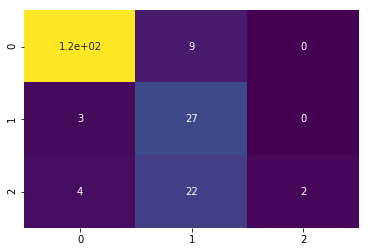

In [206]:
sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

## Save the model

In [207]:
from joblib import dump, load
dump(best_model, '../models/rfc_v03.joblib') 

['../models/rfc_v03.joblib']